In [1]:
#!pip install tensorflow opencv-python matplotlib

import tensorflow as tf
import os


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu,True)
tf.config.list_physical_devices('GPU')

[]

In [86]:
import cv2
import imghdr
data_dir = 'data'
image_exts = ['jpeg', 'jpg']
for image_class in os.listdir(data_dir)[1:]:
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            print("Failed with: ", e)

In [87]:
import numpy as np
from matplotlib import pyplot as plt

data = tf.keras.utils.image_dataset_from_directory('data')

Found 1880 files belonging to 5 classes.


In [88]:
dir_path = os.listdir('data')
print(dir_path)

['.DS_Store', 'bell-tower', 'kenan-stadium', 'wilson-library', 'old-well', 'ackland']


In [89]:
data_iterator = data.as_numpy_iterator();

batch = data_iterator.next()

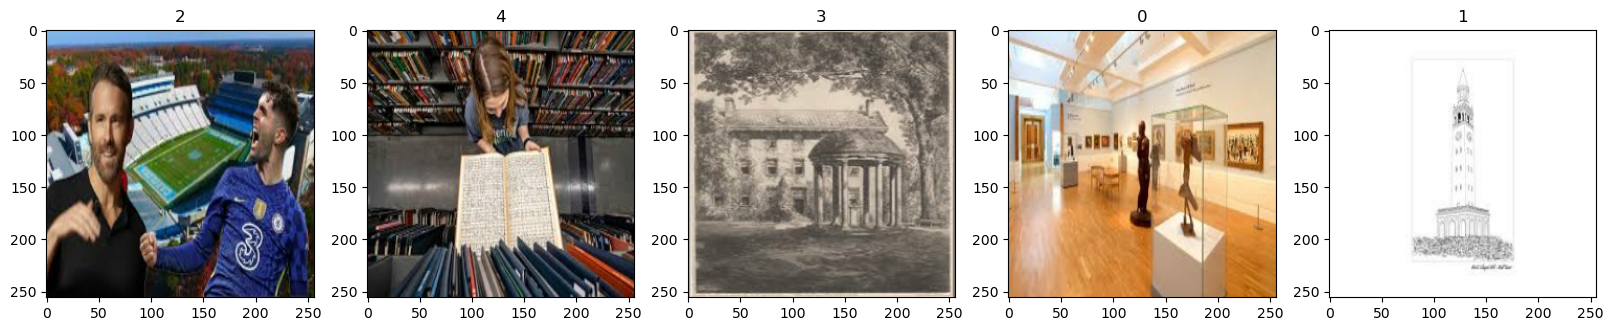

In [90]:
fig, ax = plt.subplots(ncols = 5, figsize = (20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [91]:
data = data.map(lambda x,y: (x/255,y))

train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)


print("Train Size:", train_size)
print("Validation Size:", val_size)
print("Test Size:", test_size)

Train Size: 41
Validation Size: 11
Test Size: 5


In [92]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))


model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_83 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 127, 127, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 30, 30, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,909 (14.11 MB)

 Trainable params: 3,697,781 (14.11 MB)

 Non-trainable params: 128 (512.00 B)

In [95]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=20, validation_data=val, callbacks = [tensorboard_callback])

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 464ms/step - accuracy: 0.4773 - loss: 3.4545 - val_accuracy: 0.2898 - val_loss: 2.8687
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 440ms/step - accuracy: 0.8288 - loss: 0.7333 - val_accuracy: 0.1818 - val_loss: 6.2238
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 495ms/step - accuracy: 0.9309 - loss: 0.2106 - val_accuracy: 0.2045 - val_loss: 12.1893
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 435ms/step - accuracy: 0.9741 - loss: 0.1124 - val_accuracy: 0.2017 - val_loss: 8.7235
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 450ms/step - accuracy: 0.9823 - loss: 0.0688 - val_accuracy: 0.1790 - val_loss: 11.0320
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 420ms/step - accuracy: 0.9864 - loss: 0.0453 - val_accuracy: 0.2528 - val_loss: 8.2215
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 473ms/step - accuracy: 0.9875 - loss: 0.0552 - val_accuracy: 0.3125 - val_loss: 5.4412
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 560ms/step - accuracy: 0.9914 - loss: 0.0430 - val_ac

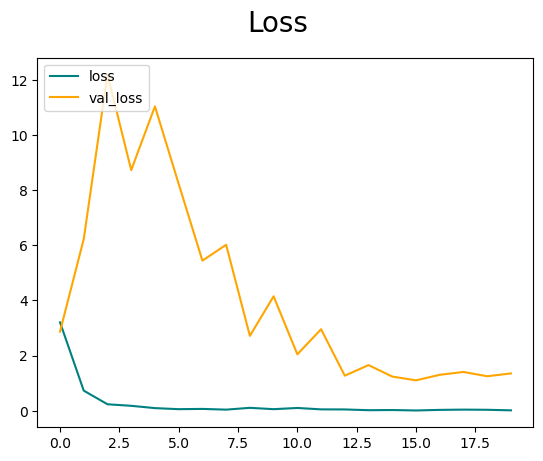

In [96]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal',label='loss')
plt.plot(hist.history['val_loss'], color = 'orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc = "upper left")
plt.show()

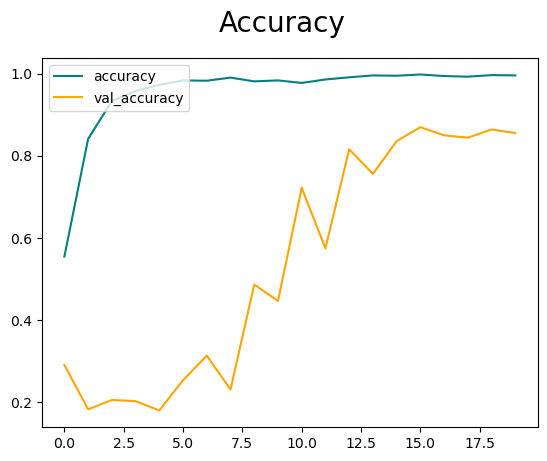

In [97]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc = "upper left")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Accuracy Score:  0.8625
Confusion matrix


2024-04-08 23:40:22.442854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


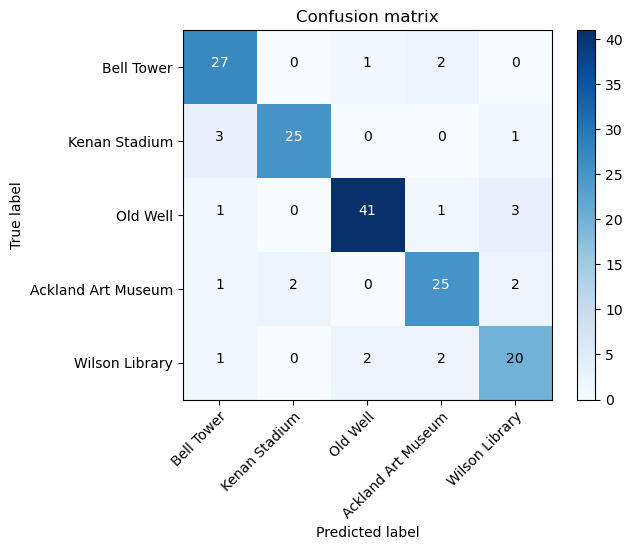

In [104]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, rotation_mode='anchor', ha = 'right')
    plt.yticks(tick_marks, classes)


    
    print('Confusion matrix')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
from sklearn.metrics import confusion_matrix


y_s = []
y_hats = []
for batch in test.as_numpy_iterator():
    X, y = batch
    y_s.append(y)
    yhat = model.predict(X)
    for hat in yhat:
        y_hats.append(np.argmax(hat))
        
flattened_ys = [item for sublist in y_s for item in sublist]
count = 0
for i in range(len(flattened_ys)):
    if flattened_ys[i]==y_hats[i]:
        count+=1
print("Accuracy Score: ", count/len(flattened_ys))
cnf_matrix = confusion_matrix(flattened_ys, y_hats)
label_set = ['Bell Tower', 'Kenan Stadium', "Old Well", 'Auckland Art Museum', 'Wilson Library']
plot_confusion_matrix(cnf_matrix, ['Bell Tower', 'Kenan Stadium', "Old Well", 'Ackland Art Museum', 'Wilson Library'],
                      title='Confusion matrix')
